In [ ]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
import IPython.display as display
import random
import pathlib
warnings.filterwarnings('ignore')
%matplotlib inline
from PIL import Image
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jangedoo/utkface-new


mkdir: cannot create directory ‘/root/.kaggle’: File exists
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip utkface-new.zip

Archive:  utkface-new.zip
replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
BASE_DIR = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/utkface_aligned_cropped/UTKFace/43_1_...,43,1
1,/content/utkface_aligned_cropped/UTKFace/26_0_...,26,0
2,/content/utkface_aligned_cropped/UTKFace/35_0_...,35,0
3,/content/utkface_aligned_cropped/UTKFace/20_1_...,20,1
4,/content/utkface_aligned_cropped/UTKFace/40_0_...,40,0


In [ ]:
gender_dict = {0:'Male', 1:'Female'}

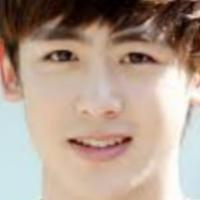

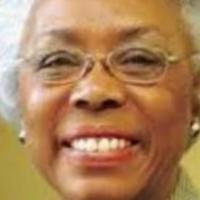

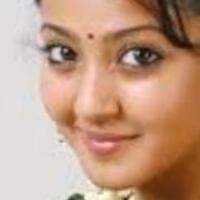

In [ ]:
for n in range(3):
  image_path = random.choice(df['image'])
  display.display(display.Image(image_path))
  print()

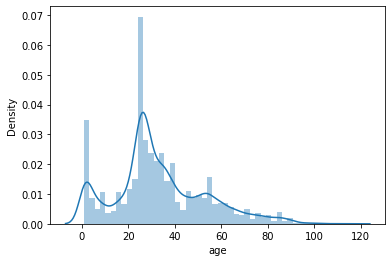

In [ ]:
sns.distplot(df['age'])

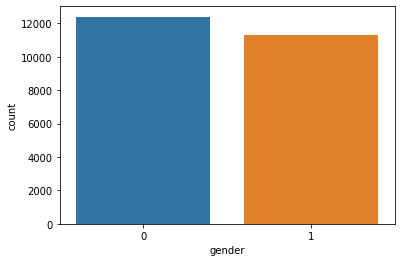

In [ ]:
sns.countplot(df['gender'])

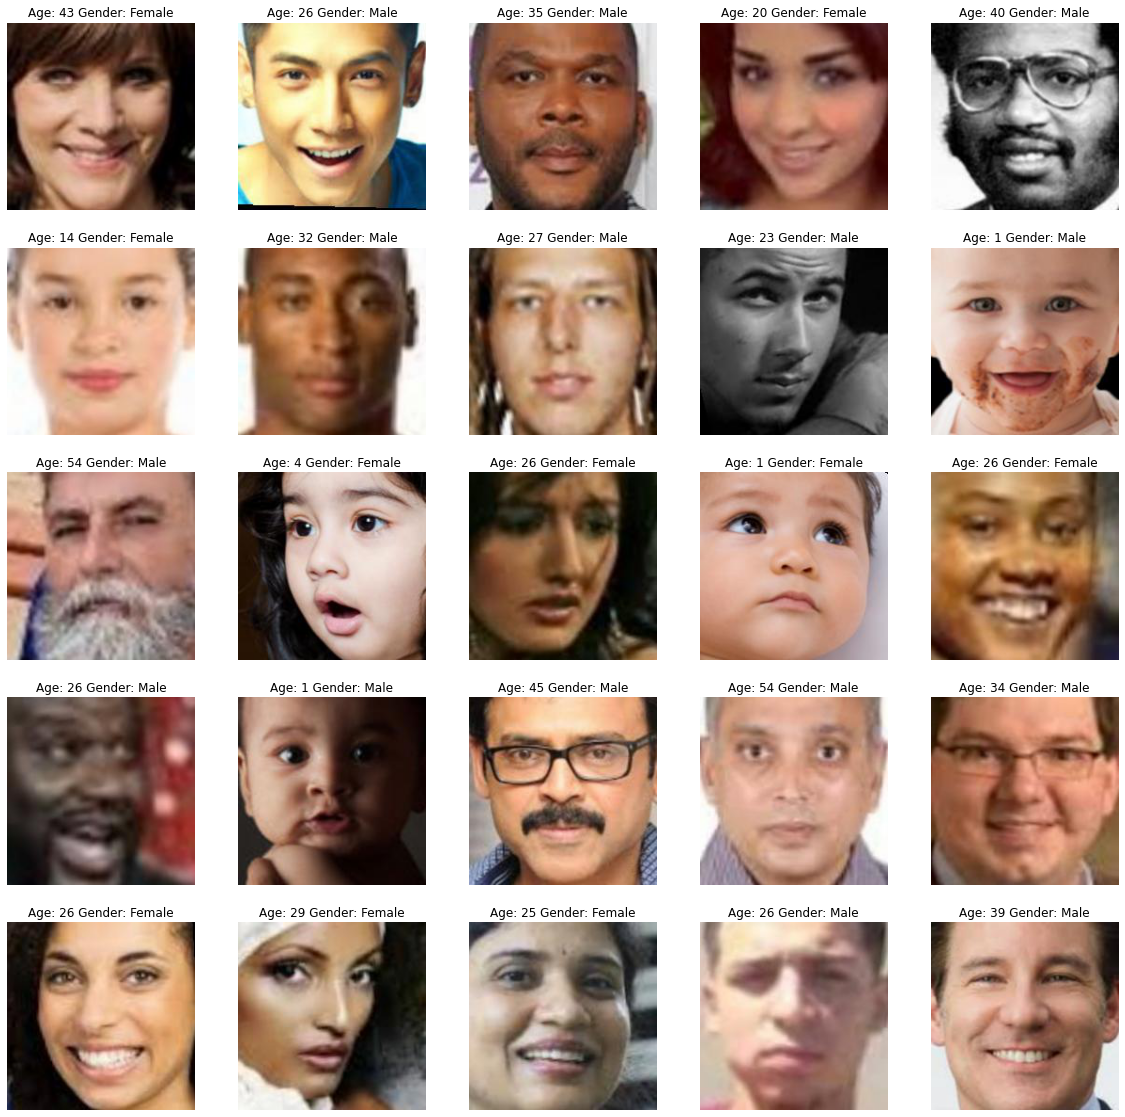

In [ ]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X/255.0

In [ ]:

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
593/593 [==============================] - 16s 22ms/step - loss: 34.5241 - gender_out_loss: 0.7982 - age_out_loss: 33.7259 - gender_out_accuracy: 0.7740 - age_out_accuracy: 4.2181e-04 - val_loss: 33.6501 - val_gender_out_loss: 0.3472 - val_age_out_loss: 33.3028 - val_gender_out_accuracy: 0.8418 - val_age_out_accuracy: 0.0000e+00
Epoch 2/10
593/593 [==============================] - 16s 27ms/step - loss: 33.6444 - gender_out_loss: 0.3408 - age_out_loss: 33.3036 - gender_out_accuracy: 0.8469 - age_out_accuracy: 0.0000e+00 - val_loss: 33.6178 - val_gender_out_loss: 0.3150 - val_age_out_loss: 33.3028 - val_gender_out_accuracy: 0.8600 - val_age_out_accuracy: 0.0000e+00
Epoch 3/10
593/593 [==============================] - 14s 23ms/step - loss: 27.2162 - gender_out_loss: 0.4180 - age_out_loss: 26.7982 - gender_out_accuracy: 0.7960 - age_out_accuracy: 0.0169 - val_loss: 14.6478 - val_gender_out_loss: 0.4922 - val_age_out_loss: 14.1556 - val_gender_out_accuracy: 0.7695 - val_age_out

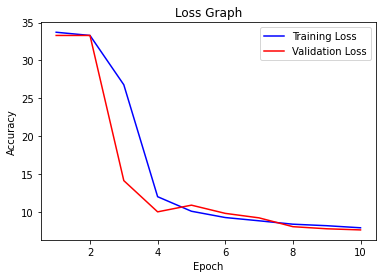

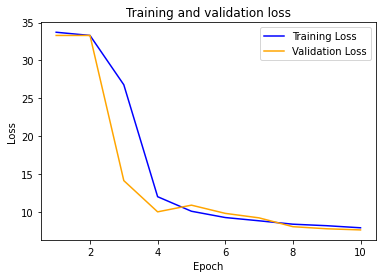

Acuuracy:  0.844247579574585


In [ ]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']

epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

plt.show()

plt.figure()

plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
print('Acuuracy: ',history.history['gender_out_accuracy'][-1])

In [ ]:
def predict(image_index):
  print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
  pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 28
1/1 [==============================] - 0s 35ms/step
Predicted Gender: Female Predicted Age: 27


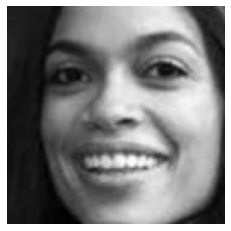

In [ ]:
predict(6063)

In [ ]:
def rand_predict():
  image_index = random.randint(0, len(df['image']))
  print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
  pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 56
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Male Predicted Age: 43


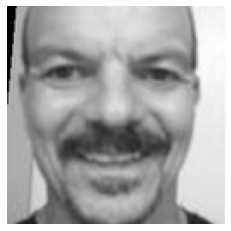

In [ ]:
rand_predict()